# Exploration of the textual dataset

Dans ce notebook, on se concentre sur le jeu de données d'entraînement textuel `X_train.csv`, que l'on nommera `df`.


## 1. Structure of the dataset


In [ ]:
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('../../data/X_train.csv')
display(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   84916 non-null  int64 
 1   designation  84916 non-null  object
 2   description  55116 non-null  object
 3   productid    84916 non-null  int64 
 4   imageid      84916 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.2+ MB


None

On peut déjà relever les informations suivantes :
- Le dataset possède **84916 lignes** et **5 colonnes**.
- Une colonne ne semble contenir aucune information pertinente : `Unnamed: 0`.
- A l'exception de la colonne `description`, le dataset n'a pas de valeurs manquantes.

Jetons un oeil aux premières lignes du dataset et vérifions que la colonne `Unnamed: 0` peut bien être retirée.


In [3]:
display(df.head())


,Unnamed: 0,designation,description,productid,imageid
0,0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786


In [4]:
# Drop column 'Unnamed: 0' if it matches the indexes

if df['Unnamed: 0'].equals(df.index.to_series()):
    df = df.drop(columns=['Unnamed: 0'])

display(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   designation  84916 non-null  object
 1   description  55116 non-null  object
 2   productid    84916 non-null  int64 
 3   imageid      84916 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.6+ MB


None

La colonne inutile a été retirée. On peut maintenant s'intéresser aux autres colonnes.


## 2 - Discovery of the features

### 2.1 - `productid` and `imageid`

Les colonnes `productid` et `imageid` correspondent de part leurs noms aux identifiants Rakuten du produit et son/ses image(s). Elles seront nécessaires pour lier les informations d'un produit (nom, description) à son/ses image(s).

A priori, un produit possède **un** intitulé et **une** description, mais **une ou plusieurs** photos. Ainsi, une valeur de la colonne `productid` sera dédoublée si et seulement si plusieurs images du produit sont présentes. La paire (`productid`, `imageid`), quant à elle, reste unique. Vérifions-le.


In [5]:
print(f"Number of duplicates : {df[['productid', 'imageid']].duplicated().sum()}")
print(f"Number of products with multiple images : {df['productid'].duplicated().sum()}")


Number of duplicates : 0
Number of products with multiple images : 0


On a donc un dataset avec **une** image pour **un** produit. On peut raisonnablement penser que l'image correspondante est la première du produit (celle vue lorsqu'on consulte une liste de résultats de recherche sur la plateforme).


### 2.2 - `designation` and `description`

La colonne `designation` correspond à l'intitulé du produit, et `description` correspond aux détails de celui-ci. Un descriptif du produit n'est pas obligatoire sur la plateforme Rakuten, et explique les valeurs manquantes de cette colonne.
Découvrons maintenant la colonne `designation`. C'est une feature textuelle, on doit donc inspecter les caractères présents pour relever ceux qui ne sont pas standards et/ou qui s'avéreront inutiles/contraignants pour nos modèles. Ecrivons une fonction qui renvoie une liste de tous les caractères qui ne sont ni alphanumériques, ni de la ponctuation standard.


In [6]:
def get_special_characters(serie: pd.Series) -> list[str]:
    special_characters = set()
    for value in serie:
        if pd.isna(value):
            continue
        for char in value:
            if not char.isalpha() and not char.isdigit() and char not in string.punctuation:
                special_characters.add(char)
    return sorted(special_characters)


On identifie alors les caractères spéciaux qu'il faudra traiter. Comme `'description'` est aussi un champ textuel, on applique la fonction précédente aux deux features.


In [7]:
designation_special_chars = get_special_characters(df['designation'])
description_special_chars = get_special_characters(df['description'])

print(f"Number of distinct special characters in 'designation' : {len(designation_special_chars)}")
print(f"Number of distinct special characters in 'description' : {len(description_special_chars)}")
print()
print(f"Special characters in 'designation' : {designation_special_chars}")
print(f"Special characters in 'description' : {description_special_chars}")


Number of distinct special characters in 'designation' : 26
Number of distinct special characters in 'description' : 47

Special characters in 'designation' : [' ', '\x80', '\x8c', '\x91', '\x92', '\x93', '\x94', '\x96', '\x97', '\x9c', '¡', '¢', '¥', '§', '©', '«', '¬', '\xad', '®', '°', '±', '´', '»', '¿', '×', '’']
Special characters in 'description' : ['\t', '\n', '\r', ' ', '\x7f', '\x80', '\x85', '\x87', '\x92', '\x93', '\x94', '\x95', '\x96', '\x99', '\x9c', '\xa0', '¡', '¢', '£', '¥', '§', '©', '«', '¬', '\xad', '®', '¯', '°', '±', '´', '·', '¸', '»', '½', '¿', '×', '\u2003', '\u2005', '\u200b', '–', '‘', '’', '“', '”', '„', '•', '…']


On a un certain nombre de caractères spéciaux à gérer (ré-encodage, suppression, ...). Certains d'entre eux (guillements, espaces, retour ligne, tabulations, etc) sont standards mais doivent tout de même être pris en compte et traités. Une analyse poussée doit être réalisée pour s'assurer que l'ensemble des caractères soit interprétable par les modèles.

En pratique, il se peut que la description d'un produit se trouve dans son intitulé (donc dans `designation`). Il en résulte que l'information normalement récupérable dans la colonne `description` sera retrouvée dans la colonne `designation`. On se propose d'analyser la distribution de la longueur des chaines de caractères dans la colonne `designation` en fonction de l'état de la description (valeur manquante ou non). Par la même occasion, on va calculer les statistiques de base de cette distribution.


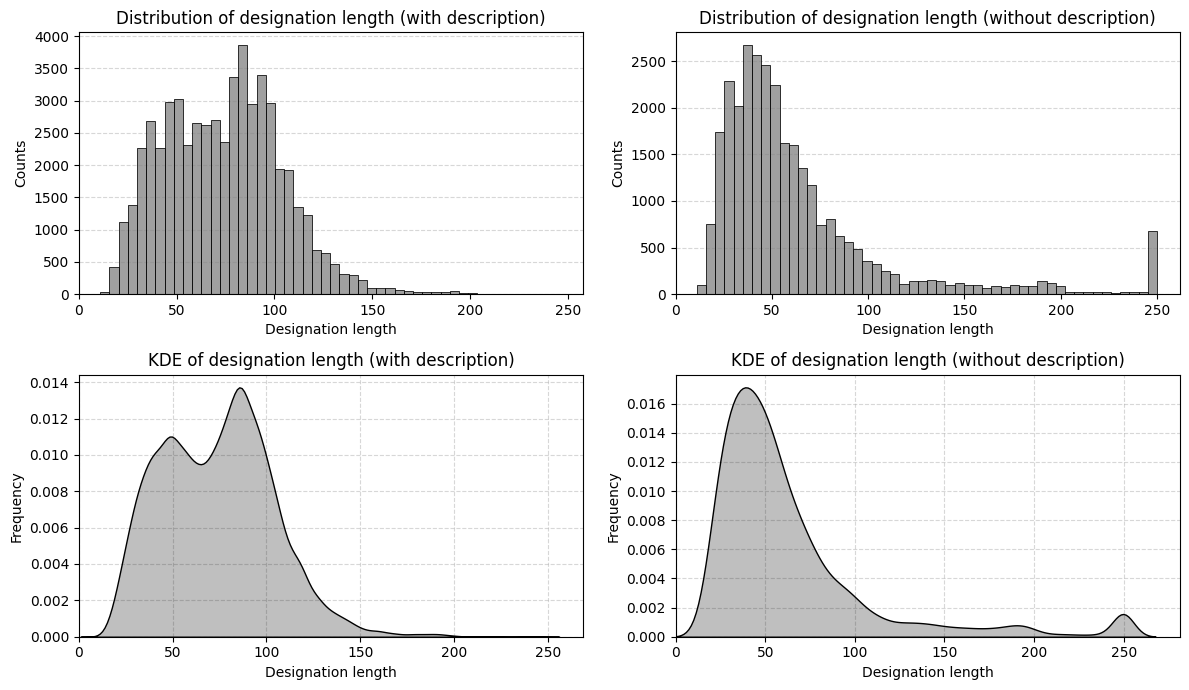

Stats of designation length with description :
	 mean : 73.67
	 median : 74.00
	 stddev : 29.81
Stats of designation length without description :
	 mean : 63.67
	 median : 50.00
	 stddev : 46.36


In [ ]:
df['designation_length'] = df['designation'].apply(lambda s: len(s))
df['missing_description'] = df['description'].apply(lambda s: 'yes' if pd.isna(s) else 'no')


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))

sns.histplot(df[df['missing_description'] == 'no']['designation_length'], bins=50, color='gray', ax=ax[0, 0], zorder=2)  # histogram with description
sns.kdeplot(df[df['missing_description'] == 'no']['designation_length'], fill=True, color='black', ax=ax[1, 0], zorder=2)  # kde with description

sns.histplot(df[df['missing_description'] == 'yes']['designation_length'], bins=50, color='gray', ax=ax[0, 1], zorder=2)  # histogram without description
sns.kdeplot(df[df['missing_description'] == 'yes']['designation_length'], fill=True, color='black', ax=ax[1, 1], zorder=2)  # kde without decription

ax[0, 0].set_title('Distribution of designation length (with description)')
ax[0, 0].set_xlabel('Designation length')
ax[0, 0].set_ylabel('Counts')
ax[0, 0].set_xlim(left=0)
ax[0, 0].grid(visible=True, linestyle='--', alpha=0.5, zorder=0, axis='y')

ax[1, 0].set_title('KDE of designation length (with description)')
ax[1, 0].set_xlabel('Designation length')
ax[1, 0].set_ylabel('Density')
ax[1, 0].set_xlim(left=0)
ax[1, 0].grid(visible=True, linestyle='--', alpha=0.5, zorder=0)

ax[0, 1].set_title('Distribution of designation length (without description)')
ax[0, 1].set_xlabel('Designation length')
ax[0, 1].set_ylabel('Counts')
ax[0, 1].set_xlim(left=0)
ax[0, 1].grid(visible=True, linestyle='--', alpha=0.5, zorder=0, axis='y')

ax[1, 1].set_title('KDE of designation length (without description)')
ax[1, 1].set_xlabel('Designation length')
ax[1, 1].set_ylabel('Density')
ax[1, 1].set_xlim(left=0)
ax[1, 1].grid(visible=True, linestyle='--', alpha=0.5, zorder=0)

plt.tight_layout()
plt.show()


print("Stats of designation length with description :")
print(f"\t mean : {df[df['missing_description'] == 'no']['designation_length'].mean():.2f}")
print(f"\t median : {df[df['missing_description'] == 'no']['designation_length'].median():.2f}")
print(f"\t stddev : {df[df['missing_description'] == 'no']['designation_length'].std():.2f}")

print("Stats of designation length without description :")
print(f"\t mean : {df[df['missing_description'] == 'yes']['designation_length'].mean():.2f}")
print(f"\t median : {df[df['missing_description'] == 'yes']['designation_length'].median():.2f}")
print(f"\t stddev : {df[df['missing_description'] == 'yes']['designation_length'].std():.2f}")


A la vue de ces informations, on peut constater les choses suivantes :
- La longueur des titres des produits est en moyenne plus élevée et est plus homogène lorsqu'il y a une description. Cela peut s'expliquer par le fait qu'un individu proposant une description à son produit accorde plus d'importance aux informations transmises aux acheteurs (effort de la part du vendeur, intégration des éléments non obligatoires, etc). En conséquence, les titres sont plus précis, donc plus détaillés, donc plus longs. Ils gardent cependant une taille raisonnable (conscience que le titre doit être concis) étant donné qu'une description est présente pour détailler ces produits.
- A contrario, pour les produits sans description, la distribution est plus hétérogène et les longueurs des titres sont globalement plus faibles. On constate un important pic en bout de queue de distribution pour les longueurs de titres entre 240 et 250. On peut d'abord expliquer les longueurs globabement plus faibles par le fait qu'un individu qui ne proposerait pas de description accorde moins d'importance aux informations précises et détaillées contenues dans l'offre du produit ; la personne se limitera donc au strict minimum sur le titre du produit (on ne peut en revanche pas conclure sur la qualité du titre : un titre court, simple, concis peut être tout à fait préférable à un titre plus détaillé et plus long). Concernant le pic sur la queue de la distribution, on peut raisonnablement faire l'hypothèse que certains vendeurs intègrent la description du produit au sein du titre. On a alors un produit où le titre *est* la description ; cette sitation peut être (ou pas) volontaire de la part du vendeur. On note aussi que la queue de la distribution est bien plus importante que celle où une description est présente. Cette observation corrobore l'idée que des vendeurs intègrent la description au sein du titre du produit.
- Comme on n'observe aucune valeur supérieure à 250 caractères, il y a un nombre maximum de caractères possibles pour le titre d'un produit. L'hypothèse sur le pic observé est confirmé ici dans le sens où les vendeurs se voient bloqués par la taille limite lorsqu'il décrivent leurs produits (qui en principe peut facilement dépasser 250 caractères).

Les éléments ci-dessus nous pousse à effectuer un traitement particulier sur ces deux colonnes. Outre les traitements textuels usuels (caractères spéciaux, embedding, etc), lorsqu'une donnée $X$ possède un titre *long* et ne possède pas de description, l'idée est de doper `description` avec ce titre. Il faut alors déterminer dans quel cas un titre peut être considéré comme une description (critère sur la longueur, etc). En se basant sur les distributions précédentes, un seuil de 150 caractères peut être un candidat pertinent pour discriminer entre titre et description. In fine, la colonne `description` aura un nombre de valeurs manquantes réduit et la qualité des données sera améliorée.

En complément de l'étude précédente, on peut tracer la distribution des longueurs des descriptions. Un diagramme en boîte permet de constater que la limite n'est pas fixée à 250 (pas de limite bloquante en pratique). Pour tracer une distribution visuellement interprétable, on va se limiter à la distribution jusqu'à une certaine valeur pour éviter une distorsion dûe aux outliers. On prendra par ailleurs en compte uniquement les descriptions non vides.


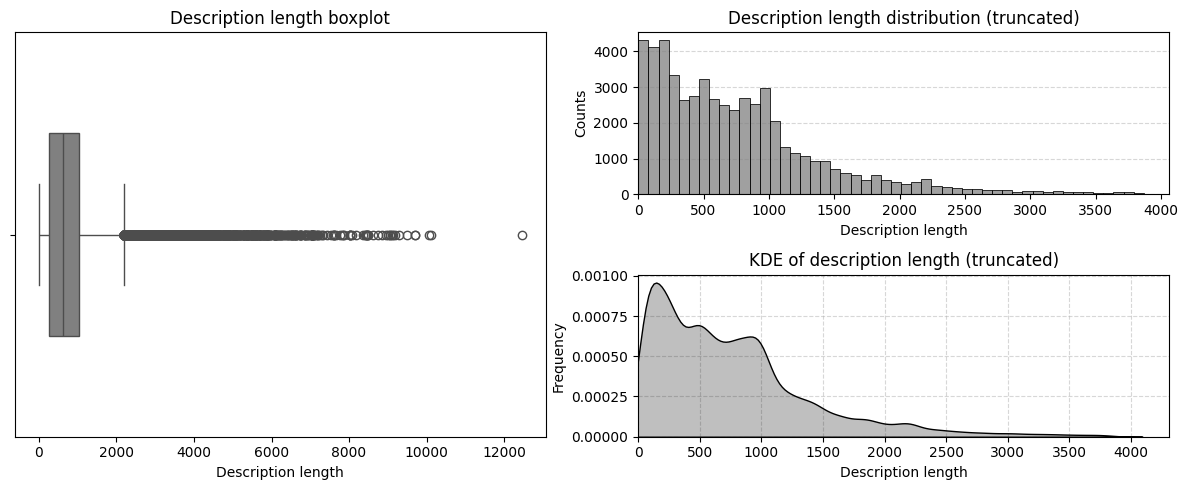

Quantile at 99% : 3869.85
Stats of truncated (99%) description length :
	 mean : 762.89
	 median : 618.00
	 stddev : 657.87
	 mode : 292.00


In [ ]:
df['description_length'] = df['description'].apply(lambda s: len(s) if isinstance(s, str) else 0)  # compute length of descriptions


fig, ax = plt.subplot_mosaic([[1, 2], [1, 3]], figsize=(12, 5))


sns.boxplot(x='description_length', data=df[df['description_length'] > 0], width=0.35, color='gray', ax=ax[1])  # boxplot of non-zero description length

ax[1].set_title('Description length boxplot')
ax[1].set_xlabel('Description length')


thres = 0.99
thres_value = df[df['description_length'] > 0]['description_length'].quantile(thres)  # compute the 99% quantile of non-zero description length


sns.histplot(df[(df['description_length'] > 0) & (df['description_length'] < thres_value)]['description_length'], bins=50, color='gray', ax=ax[2], zorder=2)  # histogram of truncated description length
sns.kdeplot(df[(df['description_length'] > 0) & (df['description_length'] < thres_value)]['description_length'], fill=True, color='black', ax=ax[3], zorder=2)  # kde of truncated description length

ax[2].set_title('Description length distribution (truncated)')
ax[2].set_xlabel('Description length')
ax[2].set_ylabel('Counts')
ax[2].set_xlim(left=0)
ax[2].grid(visible=True, linestyle='--', alpha=0.5, zorder=0, axis='y')

ax[3].set_title('KDE of description length (truncated)')
ax[3].set_xlabel('Description length')
ax[3].set_ylabel('Density')
ax[3].set_xlim(left=0)
ax[3].grid(visible=True, linestyle='--', alpha=0.5, zorder=0)


plt.tight_layout()
plt.show()


print(f"Quantile at 99% : {thres_value:.2f}")
print(f"Stats of truncated ({100 * thres:.0f}%) description length :")
print(f"\t mean : {df[(df['description_length'] > 0) & (df['description_length'] < thres_value)]['description_length'].mean():.2f}")
print(f"\t median : {df[(df['description_length'] > 0) & (df['description_length'] < thres_value)]['description_length'].median():.2f}")
print(f"\t stddev : {df[(df['description_length'] > 0) & (df['description_length'] < thres_value)]['description_length'].std():.2f}")
print(f"\t mode : {df[(df['description_length'] > 0) & (df['description_length'] < thres_value)]['description_length'].mode()[0]:.2f}")


On constate une distribution sensiblement étalée. En moyenne, en conservant les $99\%$ des descriptions les plus raisonnables, les longueurs sont $\pm 10$ fois plus longues que les titres. On note aussi un grand nombre de descriptions considérés comme outliers. Il faudra les identifier et les traiter pour améliorer la qualité de cette feature.


## 3 - Conclusion

Dans ce notebook, l'exploration du dataset d'entraînement nous a permis d'identifier les éléments suivants :
- La colonne `Unnamed: 0` est inutile.
- La colonne `description` est la seule colonne avec des valeurs manquantes, explicable par son origine dans le contexte réel.
- La colonne `description` possède un grand nombre de données anormales à étudier et traiter.
- Les colonnes `designation` et `description` doivent être fortement nettoyées étant donnée leur type de données (longue chaîne de caractères non tous standards).
- Les valeurs manquantes de la colonne `description` peuvent partiellement être remplies en utilisant la colonne `designation`.
  
Comme ce sera le cas dans les autres notebooks, **tous ces points constituent des étapes esentielles de la phase de prétraitement du jeu de données** et seront intégrées dans le.s pipeline.s correspondante.s.


Dans le notebook `discovery-text-2.ipynb`, on se focalisera sur le dataset `Y_train` qui représente les labels à prédire dans le travail de classification.
